# FAST AI JOURNEY: INTERMEZZO.
## Documenting my fast.ai journey: FIRST KAGGLE COMPETITION.

In this new project, we will analyze the '20 Years of Games' Dataset, available on Kaggle, using what we have learned on collaborative filtering and tabular data.

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

# Tabular Models.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.tabular import *

In [3]:
import pandas as pd
import numpy as np

## Getting the Data.

The Steam Video Games Dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [4]:
#! pip install kaggle --upgrade --user

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [5]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

You're all set to download the data from [20 Years of Games](https://www.kaggle.com/egrinstein/20-years-of-games/version/2).

In [6]:
#! chmod 600 /home/jupyter/.kaggle/kaggle.json

In [7]:
path = Path('data/kaggle/microsoft')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data/kaggle/microsoft')

In [8]:
#! kaggle competitions download -c microsoft-malware-prediction  -p {path}

In [9]:
#It is better to do these manually in the terminal, for now.
#Unzip without the flags.
#! sudo chmod 700 {path}/sample_submission.csv.zip
#! sudo chmod 700 {path}/test.csv.zip
#! sudo chmod 700 {path}/train.csv.zip

#! sudo unzip -q -n {path}/sample_submission.csv.zip -d {path}
#! sudo unzip -q -n {path}/test.csv.zip -d {path}
#! sudo unzip -q -n {path}/train.csv.zip -d {path}

#! sudo chmod 700 {path}/sample_submission.csv
#! sudo chmod 700 {path}/test.csv
#! sudo chmod 700 {path}/train.csv

Tabular data should be in a Pandas `DataFrame`.

In [10]:
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_train.shape
#df_train.describe()

(8921483, 83)

In [11]:
df_test.shape

(7853253, 82)

In [12]:
#remove_cols = ['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsWIMBootEnabled', 'IsBeta', 'Census_IsFlightsDisabled', 'Census_IsFlightingInternal', 'AutoSampleOptIn', 'Census_ThresholdOptIn', 'SMode', 'Census_IsPortableOperatingSystem', 'Census_DeviceFamily', 'UacLuaenable', 'Census_IsVirtualDevice', 'ProductName', 'HasTpm', 'IsSxsPassiveMode', 'Firewall', 'AVProductsEnabled', 'RtpStateBitfield', 'OsVer', 'Platform', 'Census_IsPenCapable', 'EngineVersion', 'OsSuite', 'IeVerIdentifier', 'Census_ProcessorManufacturerIdentifier', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_OSSkuName', 'Census_OSInstallLanguageIdentifier', 'OsBuild', 'Census_OSBuildNumber', 'Processor', 'SkuEdition']
#df_train.drop(remove_cols, axis=1, inplace=True)

In [13]:
droppable_features = []

In [14]:
droppable_features.append('PuaMode')
droppable_features.append('Census_ProcessorClass')

In [15]:
pd.options.display.float_format = '{:,.4f}'.format
sk_df_train = pd.DataFrame([{'column': c, 'uniq': df_train[c].nunique(), 'skewness': df_train[c].value_counts(normalize=True).values[0] * 100} for c in df_train.columns])
sk_df_train = sk_df_train.sort_values('skewness', ascending=False)

In [16]:
sk_df_test = pd.DataFrame([{'column': c, 'uniq': df_test[c].nunique(), 'skewness': df_test[c].value_counts(normalize=True).values[0] * 100} for c in df_test.columns])
sk_df_test = sk_df_test.sort_values('skewness', ascending=False)

In [17]:
droppable_features.extend(sk_df_train[sk_df_train.skewness > 99].column.tolist())

In [18]:
droppable_features

['PuaMode',
 'Census_ProcessorClass',
 'Census_IsWIMBootEnabled',
 'IsBeta',
 'Census_IsFlightsDisabled',
 'Census_IsFlightingInternal',
 'AutoSampleOptIn',
 'Census_ThresholdOptIn',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'PuaMode',
 'Census_DeviceFamily',
 'UacLuaenable',
 'Census_IsVirtualDevice']

In [19]:
droppable_features.remove('PuaMode')

In [20]:
df_train.drop(droppable_features, axis=1, inplace=True)
df_test.drop(droppable_features, axis=1, inplace=True)

In [21]:
null_counts = df_train.isnull().sum()
null_counts = null_counts / df_train.shape[0]
null_counts[null_counts > 0.1]

null_counts = df_test.isnull().sum()
null_counts = null_counts / df_test.shape[0]
null_counts[null_counts > 0.1]

DefaultBrowsersIdentifier    0.9609
OrganizationIdentifier       0.3161
SmartScreen                  0.4455
Census_InternalBatteryType   0.7614
dtype: float64

In [22]:
df_train.DefaultBrowsersIdentifier.value_counts().head(5)

239.0000      46056
3,195.0000    42692
1,632.0000    28751
3,176.0000    24220
146.0000      20756
Name: DefaultBrowsersIdentifier, dtype: int64

In [23]:
df_train.DefaultBrowsersIdentifier.fillna(0, inplace=True)
df_test.DefaultBrowsersIdentifier.fillna(0, inplace=True)

In [24]:
df_train.SmartScreen.value_counts()

RequireAdmin    4316183
ExistsNotSet    1046183
Off              186553
Warn             135483
Prompt            34533
Block             22533
off                1350
On                  731
&#x02;              416
&#x01;              335
on                  147
requireadmin         10
OFF                   4
0                     3
Promt                 2
prompt                1
&#x03;                1
00000000              1
Enabled               1
requireAdmin          1
warn                  1
Name: SmartScreen, dtype: int64

In [25]:
trans_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}
df_train.replace({'SmartScreen': trans_dict}, inplace=True)
df_test.replace({'SmartScreen': trans_dict}, inplace=True)

In [26]:
df_train.SmartScreen.isnull().sum()

0

In [27]:
df_train.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)

In [28]:
trans_dict = {
    '˙˙˙': 'unknown', 'unkn': 'unknown', np.nan: 'unknown'
}
df_train.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)
df_test.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)

In [29]:
df_train.shape

(8921483, 70)

In [30]:
df_train.dropna(inplace=True)
df_train.shape

df_test.dropna(inplace=True)
df_test.shape

(1138869, 69)

In [30]:
#df_test.dropna(inplace=True)
df_test.shape

(7853253, 69)

In [31]:
df_train.drop('MachineIdentifier', axis=1, inplace=True)
df_test.drop('MachineIdentifier', axis=1, inplace=True)

In [32]:
df_train['SmartScreen'] = df_train.SmartScreen.astype('category')
df_train['Census_InternalBatteryType'] = df_train.Census_InternalBatteryType.astype('category')

df_test['SmartScreen'] = df_test.SmartScreen.astype('category')
df_test['Census_InternalBatteryType'] = df_test.Census_InternalBatteryType.astype('category')

cate_cols = df_train.select_dtypes(include='category').columns.tolist()
cate_cols = df_test.select_dtypes(include='category').columns.tolist()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cate_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])   

In [33]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            #df[col] = df[col].astype('category')
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

%time
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
Memory usage of dataframe is 4696.52 MB
Memory usage after optimization is: 2475.88 MB
Decreased by 47.3%
Memory usage of dataframe is 4074.26 MB
Memory usage after optimization is: 2171.94 MB
Decreased by 46.7%


In [34]:
corr_remove = []

In [35]:
corr_remove.append('Platform')
corr_remove.append('Census_OSSkuName')
corr_remove.append('Census_OSInstallLanguageIdentifier')
corr_remove.append('Processor')

In [36]:
df_train.drop(corr_remove, axis=1, inplace=True)
df_test.drop(corr_remove, axis=1, inplace=True)

In [37]:
droppable_features.extend(corr_remove)

In [38]:
print(len(droppable_features))
droppable_features

17


['Census_ProcessorClass',
 'Census_IsWIMBootEnabled',
 'IsBeta',
 'Census_IsFlightsDisabled',
 'Census_IsFlightingInternal',
 'AutoSampleOptIn',
 'Census_ThresholdOptIn',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'PuaMode',
 'Census_DeviceFamily',
 'UacLuaenable',
 'Census_IsVirtualDevice',
 'Platform',
 'Census_OSSkuName',
 'Census_OSInstallLanguageIdentifier',
 'Processor']

In [39]:
remove_cols = ['PuaMode', 'Census_ProcessorClass', 'Census_IsWIMBootEnabled', 'IsBeta', 'Census_IsFlightsDisabled', 'Census_IsFlightingInternal', 'AutoSampleOptIn', 'Census_ThresholdOptIn', 'SMode', 'Census_IsPortableOperatingSystem', 'Census_DeviceFamily', 'UacLuaenable', 'Census_IsVirtualDevice', 'Platform', 'Census_OSSkuName', 'Census_OSInstallLanguageIdentifier', 'Processor']

df_train.drop(remove_cols, axis=1, inplace=True)

#df_test.drop(remove_cols, axis=1, inplace=True)

KeyError: "['PuaMode' 'Census_ProcessorClass' 'Census_IsWIMBootEnabled' 'IsBeta' 'Census_IsFlightsDisabled'\n 'Census_IsFlightingInternal' 'AutoSampleOptIn' 'Census_ThresholdOptIn' 'SMode' 'Census_IsPortableOperatingSystem'\n 'Census_DeviceFamily' 'UacLuaenable' 'Census_IsVirtualDevice' 'Platform' 'Census_OSSkuName'\n 'Census_OSInstallLanguageIdentifier' 'Processor'] not found in axis"

In [42]:
features = [feature for feature in df_train.columns]
len(features)

65

In [43]:
augmented_features = ['min', 'mean', 'max', 'median', 'std', 'abs_mean', 'abs_median', 'abs_std', 'skew', 'kurt', 'sq_kurt']

In [44]:
def augment_df(df):
    for feature in features:  
        df[f'sq_{feature}'] = df[f'{feature}_2']
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
        df[f'repo_sq_{feature}'] = df[f'sq_{feature}'].apply(lambda x: 0 if x==0 else 1/x)
    
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)

In [39]:
valid_idx = range(len(df_train)-2000, len(df_train))

In [40]:
valid_idx

range(8919483, 8921483)

In [41]:
class roc(Callback):
    '''
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

In [41]:
dep_var = 'HasDetections'
cat_names = []
cont_names = []
procs = [FillMissing, Categorify, Normalize]

In [42]:
cate_cols

['SmartScreen', 'Census_InternalBatteryType']

In [43]:
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

In [44]:
#df_train

In [45]:
cat_names = ['AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'CountryIdentifier',
 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 
 'IsProtected', 'SmartScreen', 'Census_InternalBatteryType', 'Census_MDC2FormFactor', 
 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTypeName', 'Census_HasOpticalDiskDrive', 
 'Census_ChassisTypeName',  'Census_PowerPlatformRoleName',
  'Census_InternalBatteryType', 'Census_OSVersion',  'Census_OSArchitecture', 'Census_OSBranch',
  'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSEdition', 'Census_OSInstallTypeName',
 'Census_OSUILocaleIdentifier', 'Census_OSWUAutoUpdateOptionsName', 
 'Census_GenuineStateName', 'Census_ActivationChannel',
    'Census_FlightRing', 'Census_FirmwareManufacturerIdentifier',  'Census_FirmwareVersionIdentifier',
      'Census_IsSecureBootEnabled',  'Census_IsTouchEnabled', 'Census_IsAlwaysOnAlwaysConnectedCapable',
          'Wdft_IsGamer',  'Wdft_RegionIdentifier' , 'Census_ProcessorCoreCount',
            'Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal' ]

In [46]:
cont_names = ['Census_PrimaryDiskTotalCapacity',
'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM', 
         'Census_InternalBatteryNumberOfCharges',
             ]

In [47]:
#test = TabularList.from_df(df_train.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)
test = TabularList.from_df(df_test, path=path, cat_names=cat_names, cont_names=cont_names)

In [50]:
data = TabularDataBunch.from_df(path=path, 
                                df=df_train, 
                                    dep_var=dep_var, 
                                    valid_idx=valid_idx, 
                                    cat_names=cat_names, 
                                    cont_names=cont_names, 
                                    bs=5012,
                                    procs=procs,
                                    #test_df=df_test
                               )

In [58]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        metrics=[accuracy_thresh, roc()], use_bn=True)

In [48]:
data = (TabularList.from_df(df_train, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx)
                            #.no_split()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=5012))

In [52]:
df_test.Census_PrimaryDiskTotalCapacity.fillna(0, inplace=True)

In [49]:
y_range=(0.,1.1)

In [50]:
#learn = tabular_learner(data, layers=[200,100], metrics=accuracy_thresh)
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=accuracy)

#y_range=y_range 

In [51]:
#learn.model
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


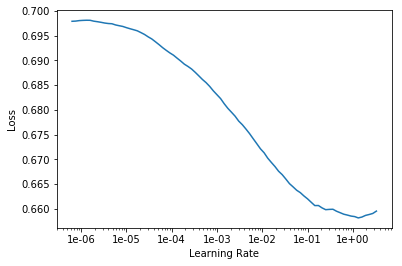

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.612175,0.619879,0.651000,09:03
1,0.605596,0.614496,0.663500,09:05
2,0.592841,0.623061,0.656000,09:06


In [55]:
learn.save('stage-1')

In [55]:
learn.load('stage-1')

NameError: name 'learn' is not defined

## Inference.

In [ ]:
#row = df_train.iloc[0]
#learn.predict(row)

In [56]:
test_preds=learn.get_preds(ds_type=DatasetType.Test)

In [57]:
test_preds

[tensor([[0.5140, 0.4860],
         [0.2719, 0.7281],
         [0.4109, 0.5891],
         ...,
         [0.6292, 0.3708],
         [0.5923, 0.4077],
         [0.6561, 0.3439]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [72]:
target_preds = test_preds[0][:,1]

In [73]:
target_preds

tensor([0.4860, 0.7281, 0.5891,  ..., 0.3708, 0.4077, 0.3439])

In [74]:
target_preds.shape

torch.Size([7853253])

In [75]:
submission = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [81]:
submission['HasDetections'] = target_preds
submission.to_csv(path/'fastai_submission3.csv', index=False)

In [84]:
df_3 = pd.read_csv(path/'fastai_submission3.csv', low_memory=False)

In [83]:
df1 = pd.read_csv(path/'lgb_submission.csv', low_memory=False)
df2 = pd.read_csv(path/'ens_sub_v12.csv', low_memory=False)

In [87]:
df4 = df1['HasDetections'] + df2['HasDetections'] + df_3['HasDetections']

In [88]:
df4 = pd.concat([df1, df2.drop(['MachineIdentifier'],axis=1), df_3.drop(['MachineIdentifier'],axis=1)], axis=1)

In [89]:
df_mean = df4.mean(axis=1)

In [90]:
df5 = df1

In [93]:
df_mean.head()

0   0.5648
1   0.6886
2   0.6778
3   0.4750
4   0.5541
dtype: float64

In [94]:
df5['HasDetections'] = df_mean

In [95]:
df5.to_csv(path/'fastai_submission4.csv', index=False)